# Homework 3
You will use the PyTorch library for all the classes and methods in this assignment. You should use a double-precision data type, and the device is either "CPU" or "cuda."

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.linalg import toeplitz

In [2]:
# importing classes
import SCAD_Class as SCAD
import Elastic_Net_Class as EN
import SQRT_Lasso_Class as SQRT

## Part 1
1) Create your own PyTorch class that implements the method of SCAD regularization and variable selection (smoothly clipped absolute deviations) for linear models. Your development should be based on the following references:

- https://andrewcharlesjones.github.io/journal/scad.html
- https://www.jstor.org/stable/27640214?seq=1

 Test your method on a real data set and determine a variable selection based on features' importance, according to SCAD. (4 points)

In [3]:
# importing housing dataset from github
housing = pd.read_csv('https://raw.githubusercontent.com/dvasiliu/AML/refs/heads/main/Data%20Sets/housing.csv')
housing = housing.drop(columns = ['town', 'tract','longitude','latitude','river','highway']) # removing categorical/string features
housing.head(2)

,crime,residential,industrial,nox,rooms,older,distance,tax,ptratio,lstat,cmedv
0,0.00632,18.0,2.31,0.538,6.575,65.199997,4.0900,296,15.300000,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.900002,4.9671,242,17.799999,9.14,21.6


In [4]:
# setting x and y variables with y being CMEDV which is Median value of owner-occupied homes in $1000's
X = housing.drop(columns=['cmedv'])
y = housing['cmedv']

#scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# turning inputs for x and y into tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
y_tensor = torch.tensor(y.values, dtype=torch.float64)

In [5]:
# performing tts on data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=440)

In [6]:
#setting a random seed so results are reproducible
torch.manual_seed(440)

# initializing the SCADLinearRegression model from .py file
model = SCAD.SCADLinearRegression(input_size=X_train.shape[1], lambda_val=.01, a_val=2.5)

#fitting the model
model.fit(X_train, y_train)

# getting the coefficients learned by the model after training
coefficients = model.get_coefficients().detach().cpu().numpy()
print("Coefficients:", coefficients)

# making predictions on the test set (X_test)
predictions = model.predict(X_test)
#print("Predictions:", predictions)

epoch: 100/2000, Loss: 373.73065308898913
epoch: 200/2000, Loss: 257.72626911325625
epoch: 300/2000, Loss: 180.99697091665817
epoch: 400/2000, Loss: 129.57883221085012
epoch: 500/2000, Loss: 95.02195591536142
epoch: 600/2000, Loss: 71.7702101340218
epoch: 700/2000, Loss: 56.109388799087384
epoch: 800/2000, Loss: 45.548529402143586
epoch: 900/2000, Loss: 38.41573110746524
epoch: 1000/2000, Loss: 33.58843749985296
epoch: 1100/2000, Loss: 30.31271051280762
epoch: 1200/2000, Loss: 28.082024553862205
epoch: 1300/2000, Loss: 26.555952750683883
epoch: 1400/2000, Loss: 25.505604034961078
epoch: 1500/2000, Loss: 24.777003111709643
epoch: 1600/2000, Loss: 24.26650777711772
epoch: 1700/2000, Loss: 23.90430325105072
epoch: 1800/2000, Loss: 23.643317190722854
epoch: 1900/2000, Loss: 23.451773370586448
epoch: 2000/2000, Loss: 23.308188336266586
Coefficients: [[-0.81646896  0.65674727 -0.66842402 -0.76813385  2.75073084 -0.23592049
  -2.33653034 -0.31554764 -1.53764449 -3.7154121 ]]


### Findings

The coefficients as found above rounded: 
- crime:&nbsp;&nbsp; -0.816
- residential:&nbsp;&nbsp;  0.657
- industrial:&nbsp;&nbsp;   -0.668
- nox:&nbsp;&nbsp;   -0.768
- rooms:&nbsp;&nbsp;   2.751	
- older:&nbsp;&nbsp;   -0.236
- distance:&nbsp;&nbsp;   -2.337	
- tax:&nbsp;&nbsp;   -0.316	
- ptratio:&nbsp;&nbsp;   -1.538
- lstat:&nbsp;&nbsp;   -3.715

The positive coefficients indicate that an increase in the feature corresponds to an increase in predicted median home value (ex. as rooms increases, so does predicted median home value).

The negative coefficients indicate than an increase in the feature corresponds to a decrease in predicted median home value (ex. as distance increases, predicted median home value decreases).

Based on these coefficients, we can determine that rooms, ptratio, and lstat are all very significant variables in predicting median home value and should therefore stay in our model. None of the variables have zero-coefficients, meaning they are all contributing something to the model, so all of the features should likely stay; however, the features older and tax are contribting the least to the model. 

## Part 2

Based on the simulation design explained in class, generate 200 data sets where the input features have a strong correlation structure (you may consider a 0.9) and apply ElasticNet, SqrtLasso and SCAD to check which method produces the best approximation of an ideal solution, such as a "betastar" you design with a sparsity pattern of your choice.

### Code

In [7]:
# Generating 200 data sets where inputs have correlation of .9, this code is based on Penalized Regression with PyTorch notebook example.
def make_correlated_features(num_samples,p,rho):
  vcor = []
  for i in range(p):
    vcor.append(rho**i)
  r = toeplitz(vcor)
  mu = np.repeat(0,p)
  x = np.random.multivariate_normal(mu, r, size=num_samples)
  return x

rho =0.9 # correlation
p = 15 # number of features
n = 200 # number of samples
vcor = []
for i in range(p):
  vcor.append(rho**i)


x = make_correlated_features(n,p,rho)

In [8]:
beta =np.array([-1,0,0,2,2,-3,-1,0,4,3]) # setting true coefficients for model
beta = beta.reshape(-1,1) # reshaping to be column vector

# filling the rest of betas with zeros so there is a coefficient for each feature (we have 15 features and only set 10 coefficients)
betastar = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0) 
# finding y variable with added noise
y = x@betastar + 1.5*np.random.normal(size=(n,1))

In [9]:
# creating tensors from x and y with double precision
x_tensor = torch.tensor(x, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.float64)

In [10]:
# initializes and fits the model to the training data,then retrieves and flattens the learned coefficients into a numpy array

elastic_net = EN.ElasticNet(input_size=p, alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x_tensor, y_tensor)
learned_coefficients_el = elastic_net.get_coefficients().detach().numpy().flatten()

sqrt_lasso = SQRT.SqrtLasso(input_size=p, alpha = .1)
sqrt_lasso.fit(x_tensor, y_tensor)
learned_coefficients_sl = sqrt_lasso.get_coefficients().detach().numpy().flatten() 

scad_model = SCAD.SCADLinearRegression(input_size=p, lambda_val=.01, a_val=2.0)
scad_model.fit(x_tensor, y_tensor, num_epochs=1000, learning_rate=.01)
learned_coefficients_scad = scad_model.get_coefficients().detach().numpy().flatten()

Epoch [100/1000], Loss: 4.0788044983678695
Epoch [200/1000], Loss: 3.3471490901845047
Epoch [300/1000], Loss: 2.9872301954440426
Epoch [400/1000], Loss: 2.782351525455871
Epoch [500/1000], Loss: 2.6601109951214554
Epoch [600/1000], Loss: 2.585032518349653
Epoch [700/1000], Loss: 2.538231926826157
Epoch [800/1000], Loss: 2.507820937282077
Epoch [900/1000], Loss: 2.4876015396762625
Epoch [1000/1000], Loss: 2.4738721998072113
Epoch [100/1000], Loss: 3.730303954390288
Epoch [200/1000], Loss: 3.30325462676298
Epoch [300/1000], Loss: 3.1027822201472355
Epoch [400/1000], Loss: 2.957817642838785
Epoch [500/1000], Loss: 2.850349607047089
Epoch [600/1000], Loss: 2.791300888173902
Epoch [700/1000], Loss: 2.7585069369231796
Epoch [800/1000], Loss: 2.741452735676023
Epoch [900/1000], Loss: 2.735649723831341
Epoch [1000/1000], Loss: 2.7341206345615765
epoch: 100/1000, Loss: 4.88192149069862
epoch: 200/1000, Loss: 3.0706792908934686
epoch: 300/1000, Loss: 2.3540865001322286
epoch: 400/1000, Loss: 2.0

In [11]:
# creating a dataframe to easily compare true coefficients with learned coefficients from three models
coef_data = {
    "True Coefficients": betastar.flatten(),
    "ElasticNet Coefficients": learned_coefficients_el,
    "SqrtLasso Coefficients": learned_coefficients_sl,
    "SCAD Coefficients": learned_coefficients_scad
}

df = pd.DataFrame(coef_data)
pd.set_option('display.float_format', '{:.4f}'.format)
df

,True Coefficients,ElasticNet Coefficients,SqrtLasso Coefficients,SCAD Coefficients
0,-1,-0.5448,-0.4056,-0.8483
1,0,-0.0857,0.0002,-0.2434
2,0,0.1342,0.0020,0.1573
3,2,1.4218,1.2852,1.8875
4,2,1.0564,1.0026,1.9646
5,-3,-1.4141,-1.5824,-2.6797
6,-1,-0.9920,-0.6410,-1.5573
7,0,0.3068,0.0019,0.3167
8,4,2.6237,2.8753,3.3314
9,3,2.8595,3.4573,3.5132


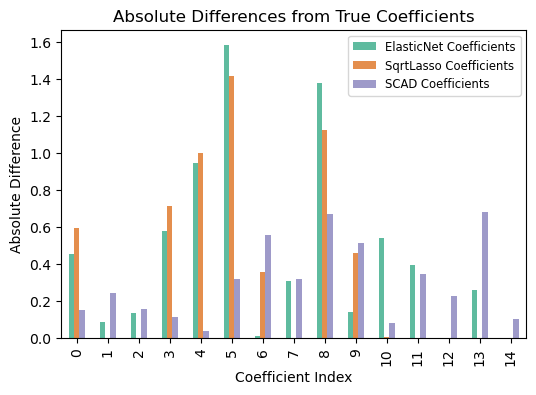

In [12]:
# creating plot to easily see the absolute differences from the true coefficient for each model
abs_diff = df.sub(df["True Coefficients"], axis=0).abs()
color_scheme = plt.get_cmap('Dark2')
abs_diff.drop(columns=["True Coefficients"]).plot(kind='bar', figsize=(6, 4), alpha=0.7, color = color_scheme.colors)
plt.title("Absolute Differences from True Coefficients")
plt.ylabel("Absolute Difference")
plt.xlabel("Coefficient Index")
plt.legend(fontsize='small')

#plt.savefig('absolute_differences.png', dpi=300, bbox_inches='tight')
plt.show()

### Findings

The graph above illustrates the absolute difference from the defined coefficient for each model. Based on this graph, SCAD is generally the closest to the true coefficients when they are non-zero coefficients. Interestingly, SCAD failed to have zero coefficients where they were defined (at indices 1, 2, 7, 10, 11, 12, 13, and 14). Square Root Lasso did a very good job of finding these zero-coefficients and Elastic-Net did a notably better job that SCAD.

## Part 3
Use the methods you implemented above to determine a variable selection for the Concrete data set with quadratic interaction terms (polynomial features of degree 2). To solve this, you should consider choosing the best weight for the penalty function. What is the ideal model size (number of variables with non-zero weights), and what is the cross-validated mean square error?

In [13]:
concrete = pd.read_csv('https://raw.githubusercontent.com/dvasiliu/AAML/refs/heads/main/Data%20Sets/concrete.csv')
concrete.head(2)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0000,0.0000,0.0000,162.0000,2.5000,1040.0000,676.0000,28,79.9900
1,540.0000,0.0000,0.0000,162.0000,2.5000,1055.0000,676.0000,28,61.8900


In [14]:
# defining X and y variables
X = concrete.drop(columns=['strength']).values
y = concrete['strength'].values

In [15]:
# creating polynomial features of degree 2 with interaction tea
poly = PolynomialFeatures(degree=2, interaction_only=True)
# transforming X by generating polynomial features, adding new columns for quadratic and interaction terms
X_poly = poly.fit_transform(X)

In [16]:
# scaling the data, MinMax Scaler had better results overall compared to StandardScaler
scaler = MinMaxScaler()
# fitting the scaler to the polynomial features and transforming
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=440)

# 10 fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=440)

In [17]:
def cross_validate_model(model_class, X, y, penalty_value):
    mse_list = []  # list to store mse from each fold
    non_zero_weights_list = [] # list to store the number of non-zero weights from each fold - how many important features there are
    
    # performing 10 fold cross-validation
    for train_idx, test_idx in kf.split(X):
        # splitting the data into training and testing sets for the current fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # converting the training and testing data into tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float64).reshape(-1, 1)
        
        # initialize and fit model
        if model_class == EN.ElasticNet:
            model = model_class(input_size=X_train.shape[1], l1_ratio=0.5, alpha=penalty_value)
        elif model_class == SQRT.SqrtLasso:
            model = model_class(input_size=X_train.shape[1], alpha=penalty_value)
        else:  # SCAD
            model = model_class(input_size=X_train.shape[1], lambda_val=penalty_value, a_val=2.5)

        # fitting the model to the training data
        model.fit(X_train_tensor, y_train_tensor, num_epochs=1000)

        # calculate mse between predicted and actual values
        y_pred = model.predict(X_test_tensor).detach().numpy()
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse) # storing mse for the fold
        
        # counting non-zero weights
        non_zero_weights = (model.linear.weight.detach().numpy() != 0).sum()
        non_zero_weights_list.append(non_zero_weights) # storing count for the fold
    
    # calculating average mse and average number of non-zero weights across all folds
    avg_mse = np.mean(mse_list)
    avg_non_zero_weights = np.mean(non_zero_weights_list)
    
    return avg_mse, avg_non_zero_weights

In [18]:
penalty_values = [.001, .01, .1, 1 , 2, 3, 4]  # penalty values to test

def grid_search_penalty(model_class, X, y, penalty_values):
    results = []  # storing results for each penalty
    best_mse = float('inf')  # setting best_mse as a high value
    non_zero_weights = 0
    
    # iterating through each penalty value
    for penalty in penalty_values:
        # cross-validating the model and getting the average MSE and non-zero weights
        avg_mse, non_zero_weights = cross_validate_model(model_class, X, y, penalty)
        results.append((penalty, avg_mse, non_zero_weights))

        # Check if the current MSE is the lowest
        if avg_mse < best_mse:
            best_mse = avg_mse # updating best mse
            best_penalty = penalty # updating penalty value for lowest mse
            non_zero_weights = non_zero_weights # updating non-zero weighs count for lowest mse

    return best_penalty, best_mse, non_zero_weights

# Perform grid search for each model
elastic_net_results = grid_search_penalty(EN.ElasticNet, X_scaled, y, penalty_values)
sqrt_lasso_results = grid_search_penalty(SQRT.SqrtLasso, X_scaled, y, penalty_values)
scad_results = grid_search_penalty(SCAD.SCADLinearRegression, X_scaled, y, penalty_values)

Epoch [100/1000], Loss: 103.44432507156942
Epoch [200/1000], Loss: 86.61746860830088
Epoch [300/1000], Loss: 77.22398585587557
Epoch [400/1000], Loss: 70.9767018249634
Epoch [500/1000], Loss: 66.60076497359627
Epoch [600/1000], Loss: 63.407783952967506
Epoch [700/1000], Loss: 60.9958314180719
Epoch [800/1000], Loss: 59.11771787676388
Epoch [900/1000], Loss: 57.61484053171668
Epoch [1000/1000], Loss: 56.38219942342768
Epoch [100/1000], Loss: 105.05977155456091
Epoch [200/1000], Loss: 88.0728146482132
Epoch [300/1000], Loss: 78.44747362404972
Epoch [400/1000], Loss: 71.98119739712897
Epoch [500/1000], Loss: 67.41621367085337
Epoch [600/1000], Loss: 64.07127900996143
Epoch [700/1000], Loss: 61.54360297493154
Epoch [800/1000], Loss: 59.58081074503306
Epoch [900/1000], Loss: 58.01889471037111
Epoch [1000/1000], Loss: 56.74765024229382
Epoch [100/1000], Loss: 102.7031546109585
Epoch [200/1000], Loss: 86.21091195500053
Epoch [300/1000], Loss: 76.89354383485498
Epoch [400/1000], Loss: 70.61703

In [19]:
print(f"ElasticNet - Best Penalty: {elastic_net_results[0]}, MSE: {elastic_net_results[1]}, Non-zero weights: {elastic_net_results[2]}")
print(f"SqrtLasso - Best Penalty: {sqrt_lasso_results[0]}, MSE: {sqrt_lasso_results[1]}, Non-zero weights: {elastic_net_results[2]}")
print(f"SCAD - Best Penalty: {scad_results[0]}, MSE: {scad_results[1]}, Non-zero weights: {elastic_net_results[2]}")

ElasticNet - Best Penalty: 0.001, MSE: 113.71899704909735, Non-zero weights: 37.0
SqrtLasso - Best Penalty: 0.001, MSE: 135.01281627102452, Non-zero weights: 37.0
SCAD - Best Penalty: 0.1, MSE: 178.72833728279727, Non-zero weights: 37.0


### Findings

Based on a very simple grid search, the best penalty value for ElasticNet and Square Root Lasso was found to be .001. For SCAD it was found to be 0.1. For all three "best" models, there were 37 non-zero weights. This means that there were 37 features that are contributing to the model. 

The model with the lowest MSE was ElasticNet with an MSE of 113.719 and 37 non-zero weights. 